In [1]:
"""
Author: GJ Both
Date: 14/11/2024
In this notebook we replace all the functions from the previous notebook by a proper implementation.
"""

# %% Imports
import jax.numpy as jnp
import matplotlib.pyplot as plt
from samples import vacuum_cylinders
from solvers import thick_sample_exact
from jax import jit
import chromatix.functional as cf
import numpy as np

%config InlineBackend.figure_format='retina'

In [2]:
# Settings
wavelength = 1.0

# %% Sample and incoming field
sample = vacuum_cylinders()
field = cf.plane_wave(
    (sample.shape[1], sample.shape[2]),
    sample.spacing,
    wavelength,
    amplitude=jnp.array([0, 1, 1]),
)



Converged in 242 iterations.
Relative error of 0.879449725151062


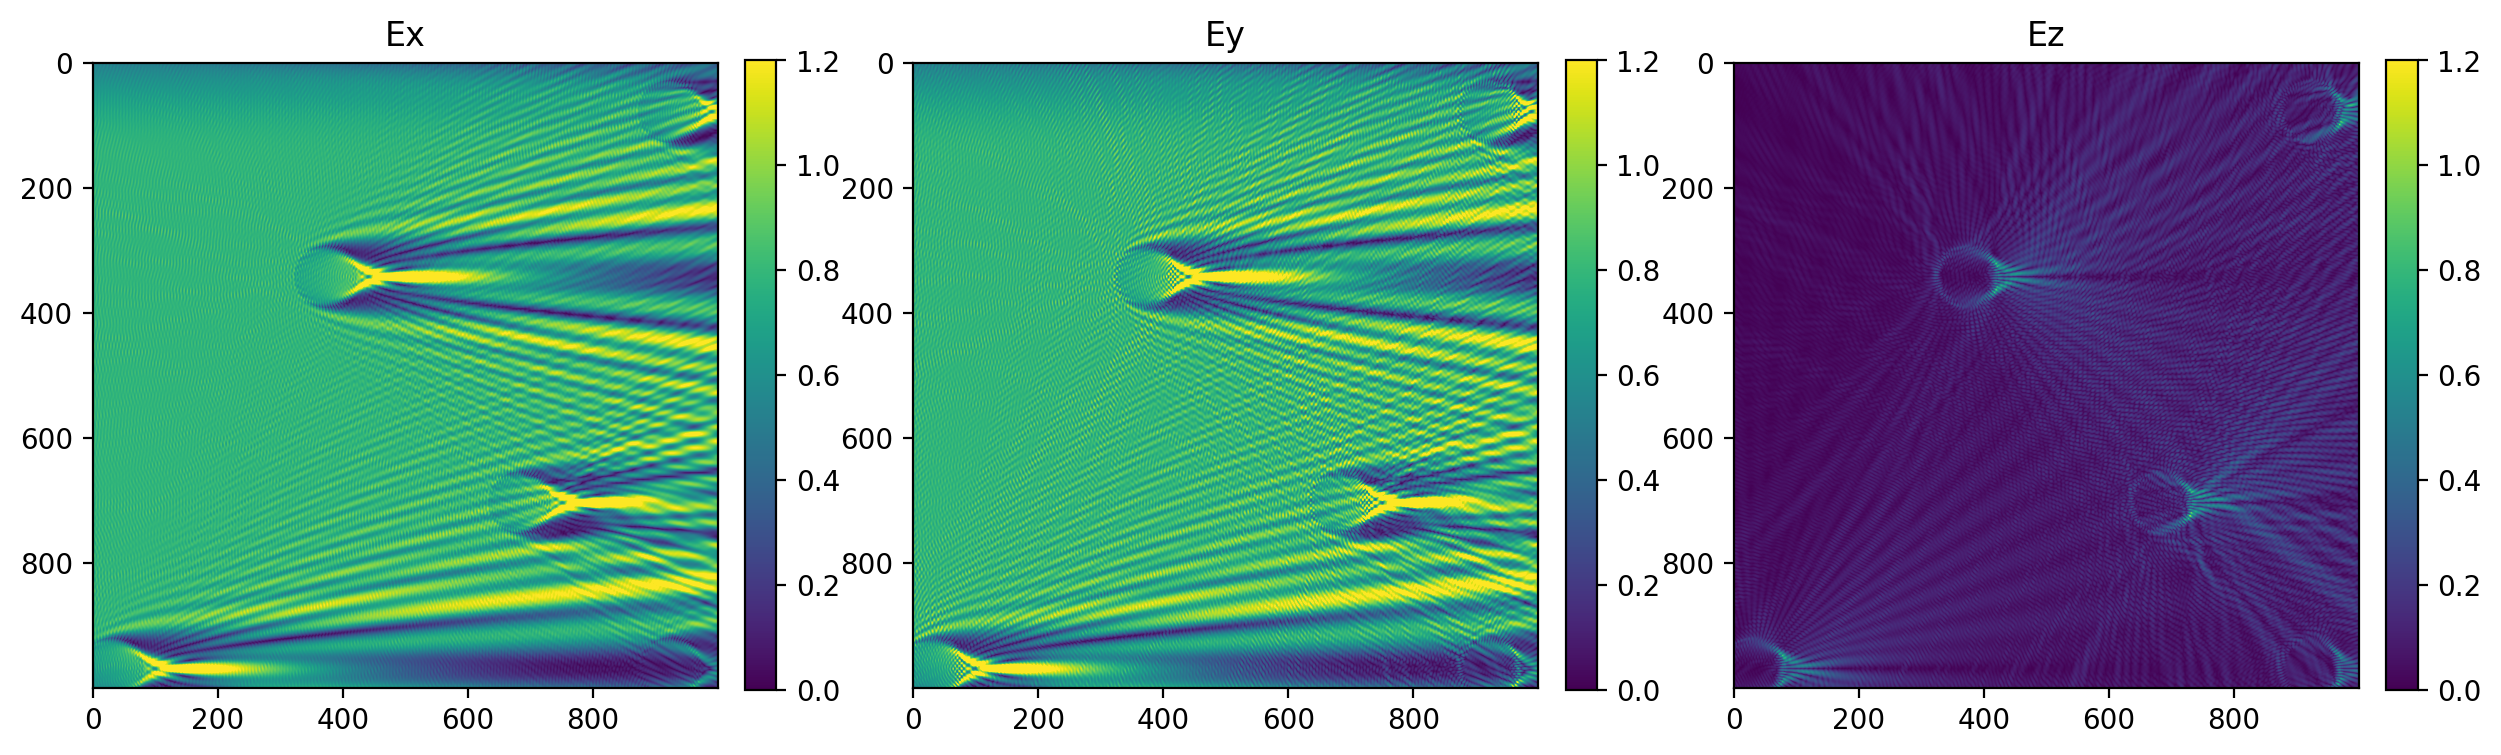

: 

In [3]:
# 250 voxels = 25 wavelengths = 25 mum
forward = jit(thick_sample_exact, static_argnames=("boundary_width", "max_steps"))
_, results = forward(field, sample, (250, None, 250), max_steps=1000)

print(f"Converged in {results.n_steps} iterations.")
print(f"Relative error of {results.rel_error}")

# %%
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Ex")
plt.imshow(
    jnp.rot90(jnp.abs(results.field[sample.roi][:, 0, :, 2])), vmin=0.0, vmax=1.2
)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(
    jnp.rot90(jnp.abs(results.field[sample.roi][:, 0, :, 1])), vmin=0.0, vmax=1.2
)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Ez")
plt.imshow(
    jnp.rot90(jnp.abs(results.field[sample.roi][:, 0, :, 0])), vmin=0.0, vmax=1.2
)
plt.colorbar(fraction=0.046, pad=0.04)

# %%

So the images look fine, but the relative error is massive! Let's plot the relative error as a function of iterations:

In [5]:
max_steps = np.linspace(10, 1000, 10, dtype=int)
rel_error = np.zeros((max_steps.size,))

for idx, max_step in enumerate(max_steps):
    _, results = forward(field, sample, (250, None, 250), max_steps=int(max_step), atol=0.0, rtol=1e-3)
    rel_error[idx] = results.rel_error

In [7]:
rel_error

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Text(0, 0.5, 'Relative error')

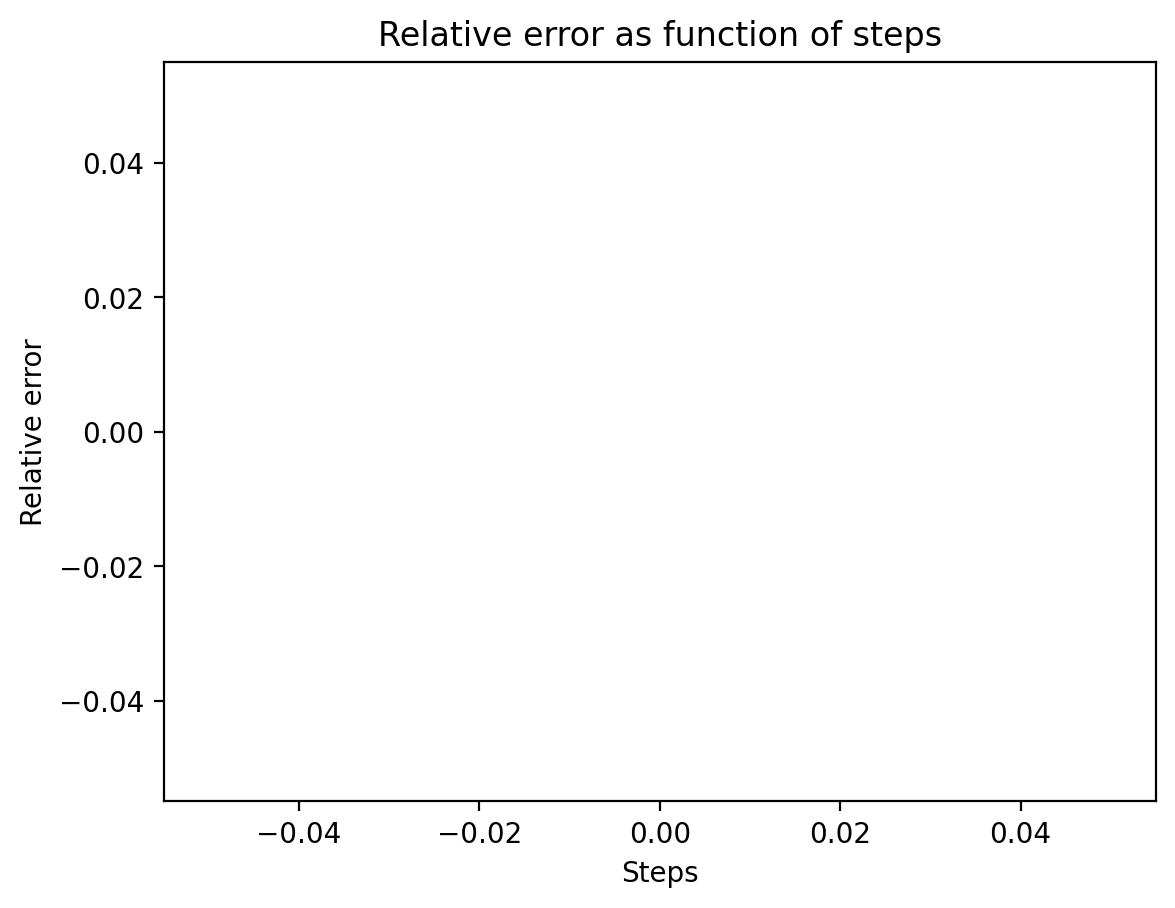

In [6]:
plt.plot(max_steps, rel_error)
plt.title("Relative error as function of steps")
plt.xlabel("Steps")
plt.ylabel("Relative error")

In [7]:
# So the error doesnt actually decrease? Implies that it's dominated by a single point? Let's check manually:
field_m = forward(field, sample, (250, None, 250), max_steps=1000)[1].field
field_n = forward(field, sample, (250, None, 250), max_steps=1001)[1].field


array([  10,  120,  230,  340,  450,  560,  670,  780,  890, 1000])

In [68]:
field_diff = np.abs(field_m - field_n).squeeze()
atol = 1e-3
rtol = 1e-3
field_rel = np.abs(field_diff / (atol + rtol * field_m.squeeze()))

In [69]:
print(f"Maximum relative error: {field_rel.max()}")
print(f"Maximum abs error: {field_diff.max()}")


Maximum relative error: 0.21032695472240448
Maximum abs error: 1.8794376046571415e-06


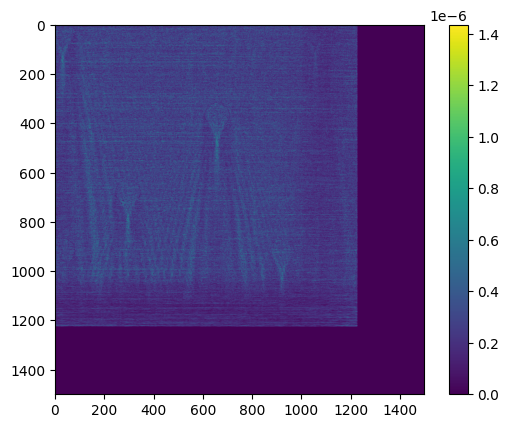

In [65]:
plt.imshow(field_diff[..., 2])
plt.colorbar()

In [9]:
# Should we just use absolute error then?
max_steps = np.linspace(10, 300, 10, dtype=int)
rel_error = np.zeros((max_steps.size,))

for idx, max_step in enumerate(max_steps):
    _, results = forward(field, sample, (250, None, 250), max_steps=int(max_step), atol=1e-4, rtol=0)
    rel_error[idx] = results.rel_error

Text(0, 0.5, 'Relative error')

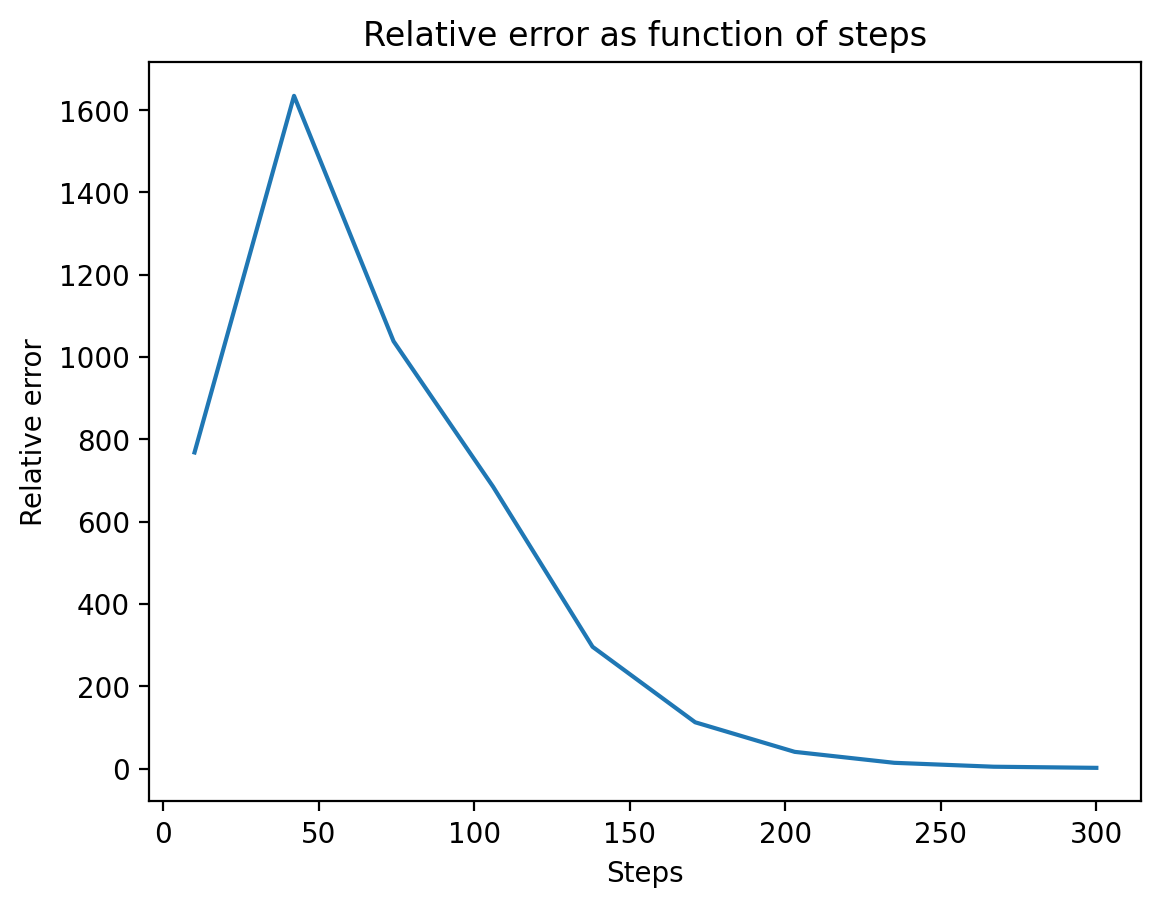

In [10]:
plt.plot(max_steps, rel_error)
plt.title("Relative error as function of steps")
plt.xlabel("Steps")
plt.ylabel("Relative error")

In [16]:
# This combo seems to work well.
_, results = forward(field, sample, (250, None, 250), max_steps=1000, atol=1e-3, rtol=1e-3)
print(results.n_steps)

242


In [6]:
results.rel_error

Array(0.947833, dtype=float32)